In [15]:
import os 
print(os.listdir("../Datasets Google/"))

['Preprocessing.ipynb', '.DS_Store', 'Desafio Final AD.pdf', 'test.csv', 'train.csv', '.ipynb_checkpoints', 'sample_submission.csv']


In [16]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import datetime as datetime
from datetime import timedelta, date
import seaborn as sns
import matplotlib.cm as CM 
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
%matplotlib inline

In [17]:
train_data = pd.read_csv("train.csv")
train_data.head()

/Users/mathias/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [18]:
train_data.describe()

,date,visitId,visitNumber,visitStartTime
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09


In [19]:
list(train_data.columns.values)

['channelGrouping',
 'date',
 'device',
 'fullVisitorId',
 'geoNetwork',
 'sessionId',
 'socialEngagementType',
 'totals',
 'trafficSource',
 'visitId',
 'visitNumber',
 'visitStartTime']

In [42]:
#Channel Grouping info - un hisograma para visualizar la frecuencias de cada atributo. en ese caso: ChannelGrouping 
#train_data.channelGrouping.value_counts().plot(kind="bar", title="ChannerGrouping", figsize=(8,8), rot=25, colormap="Paired")

In [22]:
#date está guardado en un formato String y deberia ser convertido a formato pandas datetime 
#visitStartTime está almacenado en formato "epoch unix" y tambien deberia ser convertido a formato pandas datetime
#haciendo lo siguiente, tranforma y lo guarda en el mismo dataset. 
train_data["date"] = pd.to_datetime(train_data["date"],format="%Y%m%d")
train_data["visitStartTime"] = pd.to_datetime(train_data["visitStartTime"],unit='s')

In [23]:
train_data.head(5)[["date","visitStartTime"]]

,date,visitStartTime
0,2016-09-02,2016-09-02 15:33:05
1,2016-09-02,2016-09-03 05:22:27
2,2016-09-02,2016-09-03 01:16:26
3,2016-09-02,2016-09-03 05:40:13
4,2016-09-02,2016-09-02 13:23:20


In [24]:
# el atributo device esta guardado en formato JSON, es necesario deserealizarlo para poder analizarlo 
list_of_devices = train_data.device.apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
#Si hay un feature que no está relacionado, o si contiene un "NaN" deberian ser descartados. 

In [25]:
"Claves existentes en el atributo device son:{}".format(keys)

"Claves existentes en el atributo device son:['browser', 'browserVersion', 'browserSize', 'operatingSystem', 'operatingSystemVersion', 'isMobile', 'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors', 'screenResolution', 'deviceCategory']"

In [26]:
tmp_device = pd.DataFrame(train_data.device.apply(json.loads).tolist())[["browser","operatingSystem","deviceCategory","isMobile"]]

In [45]:
tmp_device.head(500)

,browser,operatingSystem,deviceCategory,isMobile
0,Chrome,Windows,desktop,False
1,Firefox,Macintosh,desktop,False
2,Chrome,Windows,desktop,False
3,UC Browser,Linux,desktop,False
4,Chrome,Android,mobile,True
5,Chrome,Windows,desktop,False
6,Chrome,Windows,desktop,False
7,Chrome,Windows,desktop,False
8,Internet Explorer,Windows,desktop,False
9,Firefox,Windows,desktop,False


In [28]:
tmp_device.describe()

,browser,operatingSystem,deviceCategory,isMobile
count,903653,903653,903653,903653
unique,54,20,3,2
top,Chrome,Windows,desktop,False
freq,620364,350072,664479,664530


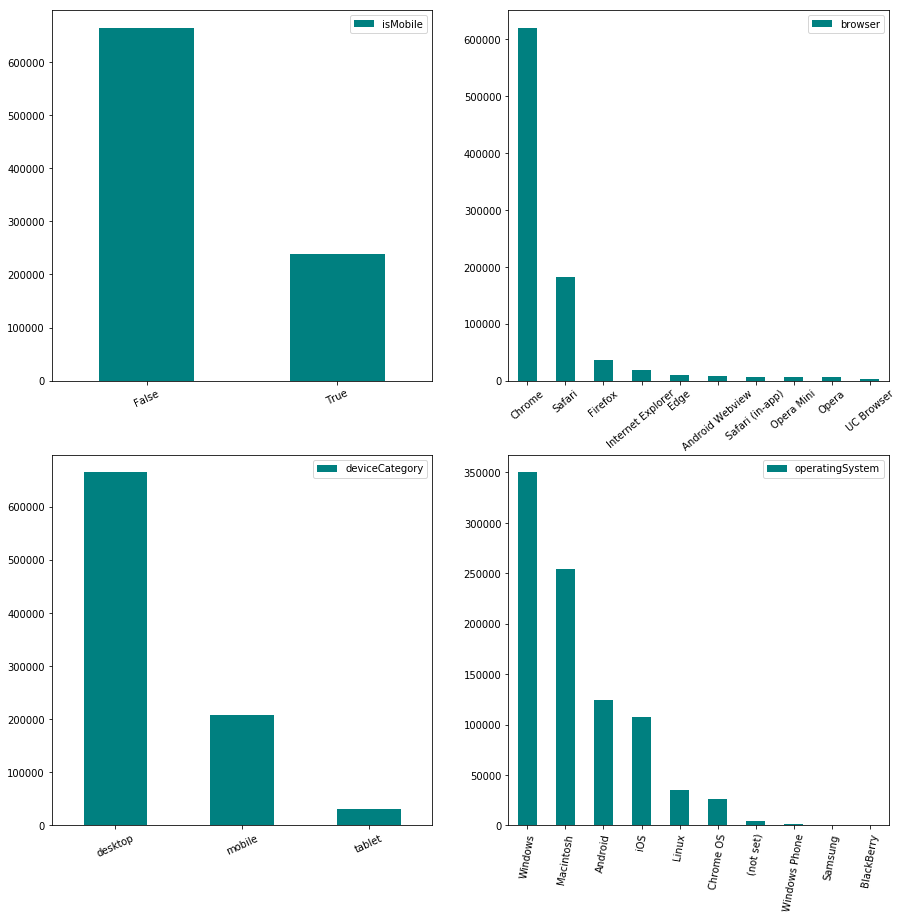

In [32]:
fig, axes = plt.subplots(2,2,figsize=(15,15))
tmp_device["isMobile"].value_counts().plot(kind="bar",ax=axes[0][0],rot=25,legend="isMobile",color='teal')
tmp_device["browser"].value_counts().head(10).plot(kind="bar",ax=axes[0][1],rot=40,legend="browser",color='teal')
tmp_device["deviceCategory"].value_counts().head(10).plot(kind="bar",ax=axes[1][0],rot=25,legend="deviceCategory",color='teal')
tmp_device["operatingSystem"].value_counts().head(10).plot(kind="bar",ax=axes[1][1],rot=80,legend="operatingSystem",color='teal')

In [34]:
#los datos correspondientes a la geoLocalizacion tambien estan en formato JSON. Hay que deserealizarlos. 
tmp_geoNet = pd.DataFrame(train_data.geoNetwork.apply(json.loads).tolist())[["continent", "subContinent", "country", "city"]]

In [35]:
tmp_geoNet.head()

,continent,subContinent,country,city
0,Asia,Western Asia,Turkey,Izmir
1,Oceania,Australasia,Australia,not available in demo dataset
2,Europe,Southern Europe,Spain,Madrid
3,Asia,Southeast Asia,Indonesia,not available in demo dataset
4,Europe,Northern Europe,United Kingdom,not available in demo dataset


In [36]:
tmp_geoNet.describe()

,continent,subContinent,country,city
count,903653,903653,903653,903653
unique,6,23,222,649
top,Americas,Northern America,United States,not available in demo dataset
freq,450377,390657,364744,508229


In [37]:
train_data.head()
train_data["revenue"] = pd.DataFrame(train_data.totals.apply(json.loads).tolist())[["transactionRevenue"]]

In [39]:
revenue_datetime= train_data[["revenue" , "date"]].dropna()
revenue_datetime["revenue"] = revenue_datetime.revenue.astype(np.int64)
revenue_datetime.head()

,revenue,date
752,37860000,2016-09-02
753,306670000,2016-09-02
799,68030000,2016-09-02
802,26250000,2016-09-02
859,574150000,2016-09-02


In [43]:
#hacemos un plot del daily revenue 
#daily_revenue = revenue_datetime.groupby(by=["date"],axis = 0 ).sum()
#import matplotlib.pyplot as plt
#fig, axes = plt.subplots(figsize=(20,10))
#axes.set_title("Daily Revenue")
#axes.set_ylabel("Revenue")
#axes.set_xlabel("date")
#axes.plot(daily_revenue["revenue"])